In [25]:
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, utils, datasets
import numpy as np
from sklearn.metrics import confusion_matrix

import mlflow
import mlflow.tensorflow

Text(0.5, 1.0, '3')

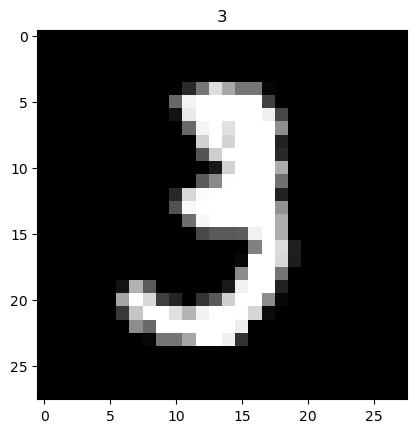

In [70]:
(X_train, y_train), (X_test, y_test) = datasets.mnist.load_data()
plt.imshow(X_train[10], cmap='gray')
plt.title(y_train[10])

In [27]:
print(X_train.shape)

(60000, 28, 28)


In [71]:
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:]))) # equivale ao flatten()
print(X_train.shape)
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))

(60000, 784)


In [72]:
# Reduzir dimensionalidade preservando 95% de sua variancia, para ocupar menos espaço. Cada instância terá pouco mais de 150 features, reduzindo 20% do tamanho
from sklearn.decomposition import PCA
pca = PCA(n_components = 300) #ou 0.95 (porém neste caso X_test fica com amostras a menos e dá erro)
X_train_reduced = pca.fit_transform(X_train)
X_test_reduced = pca.fit_transform(X_test)

In [73]:
print(X_train_reduced.shape)
print(X_test_reduced.shape)

(60000, 300)
(10000, 300)


In [31]:
print(X_train.dtype)

uint8


In [74]:
X_train_reduced = X_train_reduced.astype('float32')
print(X_train_reduced.dtype)
X_test_reduced = X_test_reduced.astype('float32')
#X_train_recovered = pca.inverse_transform(X_train_reduced)
X_train_reduced /= 255
X_test_reduced /= 255
print(X_train_reduced.dtype)

float32
float32


In [75]:
#transformando target em dummy (onehotencoder)
y_train = utils.to_categorical(y_train, 10)
y_test = utils.to_categorical(y_test, 10)

In [76]:
y_train[10]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0.])

In [79]:
from keras import regularizers

def train_nn(hidden_layers, neurons, activation_function_hidden, drop_out, epochs):
    #https://www.tensorflow.org/guide/keras/sequential_model?hl=pt-br
    model = keras.Sequential()
    
    #primeira camada oculta + camada de entrada
    model.add(layers.Dense(units=neurons, activation=activation_function_hidden, input_dim=300))
    model.add(layers.Dropout(drop_out)) #regularização

    #camadas ocultas adicionais com dropout
    for n in range(hidden_layers):
        model.add(layers.Dense(units=neurons, activation=activation_function_hidden))
        model.add(layers.Dropout(drop_out))

    #camada de saída com 10 saídas -  multiclasse com função de ativação softmax (iremos ver em regressão logística)
    model.add(layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    """Use this crossentropy loss function when there are two or more label classes. 
    We expect labels to be provided in a one_hot representation. If you want to provide labels as integers, 
    please use SparseCategoricalCrossentropy loss. There should be num_classes floating point values per feature, i.e., 
    the shape of both y_pred and y_true are [batch_size, num_classes].
    """

    model.summary()
        
    histdata = model.fit(X_train_reduced, y_train, epochs=epochs, validation_data=(X_test_reduced, y_test))
    print(histdata.history.keys())
    # plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(histdata.history['loss'], label='train')
    plt.plot(histdata.history['val_loss'], label='test')
    plt.legend()
    # plot precision during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(histdata.history['accuracy'], label='train')
    plt.plot(histdata.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()
    #loss = plt.plot(histdata.history['val_loss']) #diferenca entre predito e observado
    #pr = plt.plot(histdata.history['val_precision']) #diferença entre erros e acertos
    _, train_acc = model.evaluate(X_train_reduced, y_train, verbose=0)
    _, test_acc = model.evaluate(X_test_reduced, y_test, verbose=0)
    print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
    #plt.savefig('loss.png')
    plt.close()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_74 (Dense)                │ (None, 16)             │         4,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_53 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ (None, 10)             │           170 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,530 (21.60 KB)

 Trainable params: 5,530 (21.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.3023 - loss: 1.9511 - val_accuracy: 0.5642 - val_loss: 1.3868
Epoch 2/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.5734 - loss: 1.2960 - val_accuracy: 0.5938 - val_loss: 1.3275
Epoch 3/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6215 - loss: 1.1595 - val_accuracy: 0.5993 - val_loss: 1.3966
Epoch 4/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6391 - loss: 1.1148 - val_accuracy: 0.5950 - val_loss: 1.4530
Epoch 5/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6632 - loss: 1.0574 - val_accuracy: 0.5938 - val_loss: 1.5239
Epoch 6/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6671 - loss: 1.0272 - val_accuracy: 0.5921 - val_loss: 1.6228
Epoch 7/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6741 - loss: 1.0267 - val_accuracy: 0.5783 - val_loss: 1.7188
Epoch 8/30
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.6812 - loss: 0.9963 - 

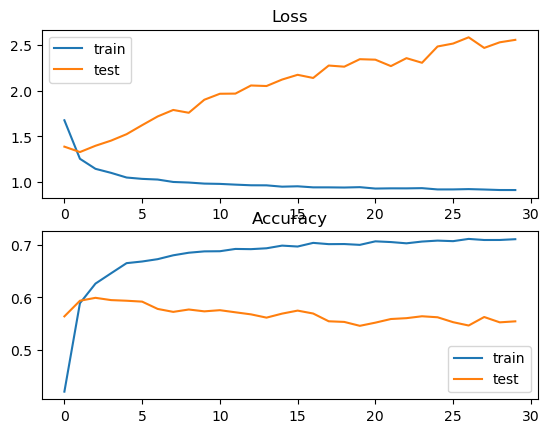

Train: 0.907, Test: 0.555


In [80]:
train_nn(2, 16,'relu',0.4, 30)

#### [TAREFA] Pesquise como usar o OPTUNA com o KERAS, criando um experimento com as sugestões de modificação abaixo, mas sugere-se ver também sugestões no chatgpt das principais técnicas para reduzir overfitting

In [27]:
"""
hidden_layers = [1, 2, 3]
neurons = [10,32,64]
activation = ['relu', 'tanh']
drop_out = [0.1, 0.2]
epochs = [5, 10, 20]

# 108 modelos

for layers in hidden_layers:
    for n in neurons:
        for act in activation:
            for drop in drop_out:
                for e in epochs:
                    train_nn(layers, n, act, drop, e)
"""

"\nhidden_layers = [1, 2, 3]\nneurons = [10,32,64]\nactivation = ['relu', 'tanh']\ndrop_out = [0.1, 0.2]\nepochs = [5, 10, 20]\n\n# 108 modelos\n\nfor layers in hidden_layers:\n    for n in neurons:\n        for act in activation:\n            for drop in drop_out:\n                for e in epochs:\n                    train_nn(layers, n, act, drop, e)\n"